# Overview

## Setup

### Installation
See `https://github.com/sagar87/spatial-data/tree/main`. It is highly recommended to perform all of this in an isolated environment, e. g. using conda or mamba.

### Basic Structure

Spatialdata has five different modules. Each module contains functions for a specific purpose, such as plotting, segmenting an image etc. The modules are:

- `pp` (preprocessing): takes care of preprocessing such as normalizing channel intensities and assigning colors to channels.
- `se` (segmentation): can quantify the marker expression of each segmented cell.
- `tl` (?): fits a Gaussian Mixture Model (GMM) to the marker expression, which enables automatic gating.
- `la` (label): used to manually assign cell types to the gated cells.
- `pl` (plotting): takes care of all things plotting, such as looking at the distribution of marker intensity or plotting cell types in the spatial context.

We will now go through each module individually and see what they can do. As an example, we look at a single sample from the BNHL_TMA data set.

## Tutorial

### Step 1: Loading the data

In [17]:
import pandas as pd
import numpy as np
import tifffile
import xarray as xr
import spatial_data
import matplotlib.pyplot as plt

In [8]:
# change this part according to the sample you want to look at
image = tifffile.imread("/home/meyerben/codex/BNHL_TMA/cropped_automated_3k/166_2_H3_LK.tif")
image.shape

(56, 3000, 3000)

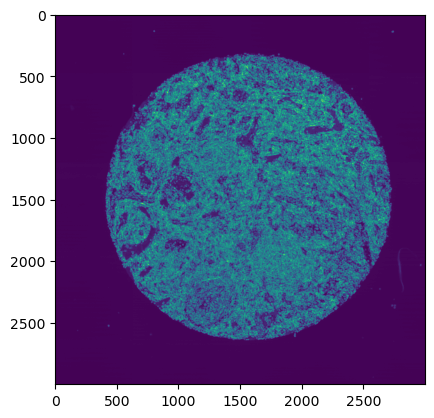

In [18]:
# look at the first channel to check if reading the file worked
plt.imshow(image[0])

From the shape, we can see that there are 56 channels, and the image is 3000px by 3000px large. In order to assign the channels correctly, we also need to read in the file containing all of the markers in the correct order.

In [13]:
markers = list(pd.read_csv("/home/meyerben/codex/BNHL_TMA/MarkerList.txt", header=None)[0])#
# looking at the first five markers
markers[0:5]

['DAPI', 'Helios', 'CD10', 'TCF7/TCF1', 'PD-L1']

Before putting everything into a single object, we also want to load in the segmentation mask. This could be obtained via StarDist, CellSeg or any other segmentation method. The segmentation mask is basically an array of shape (3000, 3000) that has 0 for the background and a number for each individual cell.

In [16]:
segmentation = tifffile.imread("/home/meyerben/codex/BNHL_TMA/segmented/visual_output/166_2_H3_LK_visual_growth_2_flat_mask.tif")
segmentation.shape

(3000, 3000)

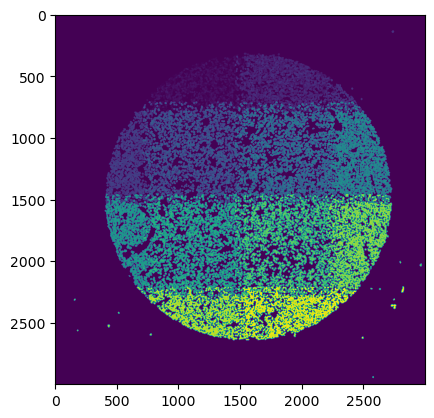

In [19]:
# visualizing the segmentation
plt.imshow(segmentation)

At this point, we have the original image, the marker names and a segmentation mask. We now want to load them into a spatialdata object, so that we can apply all of the methods that spatialdata provides. This is done via the `load_image_data()` method.

In [39]:
sd_image = spatial_data.load_image_data(image, channel_coords=markers, segmentation=segmentation)
sd_image

<xarray.Dataset>
Dimensions:        (channels: 56, y: 3000, x: 3000, cells: 14224, features: 2)
Coordinates:
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 14220 14221 14222 14223 14224
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 4 4 4 5 5 4 4 4 4 ... 2 2 3 2 2 2 2 2
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 759.3 137.6 ... 2.267e+03 2.294e+03

### Step 2: the preprocessing module
TODO.

### Step 3: the segmentation module
We have a segmentation mask, but ultimately we want a matrix that tells us the mean (or median/sum/...) intensity of each marker in each cell (analogous to a count matrix). This quantification can be accomplished using the segmentation module.

In [40]:
# by default, the quantification uses the sum_intensity
# instead, we want the mean intensity, so we have to set up a method to calculate it
# as an input, this method takes the regionmask (which is a mask that is 1 where our cell is and 0 everywhere else) and the intensity image (one image per channel)
def mean_expression(regionmask, intensity_image):
    # selecting only the intensities for our selected cell
    intensities = intensity_image[regionmask]
    # taking the mean of those intensities and returning it
    return np.mean(intensities)

# performing the quantification with our custom method
sd_image = sd_image.se.quantify(func=mean_expression)
sd_image

<xarray.Dataset>
Dimensions:        (channels: 56, y: 3000, x: 3000, cells: 14224, features: 2)
Coordinates:
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 14220 14221 14222 14223 14224
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint8 4 4 4 5 5 4 4 4 4 ... 2 2 3 2 2 2 2 2
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 759.3 137.6 ... 2.267e+03 2.294e+03
    _intensity     (cells, channels) float64 7.758 0.002431 ... 2.709 2.524

Note that our sd_image now contains a new slot called `_intensity`. We can have a look at this and export it if need may be.

In [51]:
# you can get the data as xarray.DataArray by using sd_image["_intensity"]
# here, we put it into a pandas data frame, which can easily be exported
intensity_df = pd.DataFrame(sd_image["_intensity"], columns=list(sd_image.coords["channels"].values))
intensity_df.head()

,DAPI,Helios,CD10,TCF7/TCF1,PD-L1,BCL-6,FOXP3,CD69,Perforin,CD19,...,CD68,CD31,CD45,CD3,Cytokeratin,CD45RO,CD8,Granyzme B,CD79a,Ki-67
0,7.757699,0.002431,1.683144,0.000000,0.024311,0.000000,0.000000,0.068071,0.179092,0.042139,...,0.308752,0.000000,0.055105,0.010535,5.715559,0.003241,0.259319,0.950567,0.192869,1.592382
1,53.865741,0.000000,9.546296,2.287037,14.861111,0.000000,0.023148,1.657407,7.773148,2.324074,...,0.768519,0.000000,11.125000,21.837963,3.453704,29.490741,2.462963,1.819444,2.092593,2.578704
2,64.894366,0.000000,61.169014,9.961268,22.073944,0.007042,0.070423,9.130282,10.066901,3.292254,...,1.232394,0.007042,8.845070,17.573944,4.070423,23.947183,2.929577,2.394366,3.436620,4.190141
3,37.705882,0.000000,7.009804,9.995098,10.333333,0.000000,0.000000,1.406863,5.588235,1.245098,...,0.990196,0.000000,11.450980,17.210784,2.906863,10.882353,2.191176,2.009804,1.921569,2.323529
4,17.833333,0.000000,48.230392,0.000000,5.333333,0.000000,0.009804,0.117647,2.955882,0.681373,...,0.284314,0.000000,1.308824,0.034314,2.362745,2.558824,1.284314,1.921569,2.740196,2.338235


At this point, you could save the dataframe using `intensity_df.to_csv("/your/output/path/intensity_df.csv")`. For the purposes of this demonstration, we will continue working with the spatialdata object.

### Step 4: the tl module
TODO.

### Step 5: the label module
TODO.

### Step 6: the plotting module

TODO.